In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
with open('train.json') as data_file:    
    data = json.load(data_file)

In [3]:
products_num = np.array([len(i["ingredients"]) for i in data])

In [4]:
cuisine = []
ingredients = []
ingredients_num = []
for i in data:
    if len(i["ingredients"]) < 50:
        ingredients.append(" ".join(i["ingredients"]))
        cuisine.append(i["cuisine"])
        ingredients_num.append(len(i["ingredients"]))

In [5]:
df = pd.DataFrame()
df["cuisine"] = cuisine
df["ingridients"] = ingredients
df["ingredients_num"] = ingredients_num

In [6]:
df.head()

,cuisine,ingridients,ingredients_num
0,greek,romaine lettuce black olives grape tomatoes ga...,9
1,southern_us,plain flour ground pepper salt tomatoes ground...,11
2,filipino,eggs pepper salt mayonaise cooking oil green c...,12
3,indian,water vegetable oil wheat salt,4
4,indian,black pepper shallots cornflour cayenne pepper...,20


In [7]:
(df.groupby("cuisine")["ingredients_num"].mean().reset_index()
                                         .sort_values("ingredients_num", ascending=False))

,cuisine,ingredients_num
14,moroccan,12.909866
7,indian,12.705961
19,vietnamese,12.675152
2,cajun_creole,12.617076
18,thai,12.545809
10,jamaican,12.214829
3,chinese,11.982791
12,korean,11.284337
13,mexican,10.871058
17,spanish,10.423660


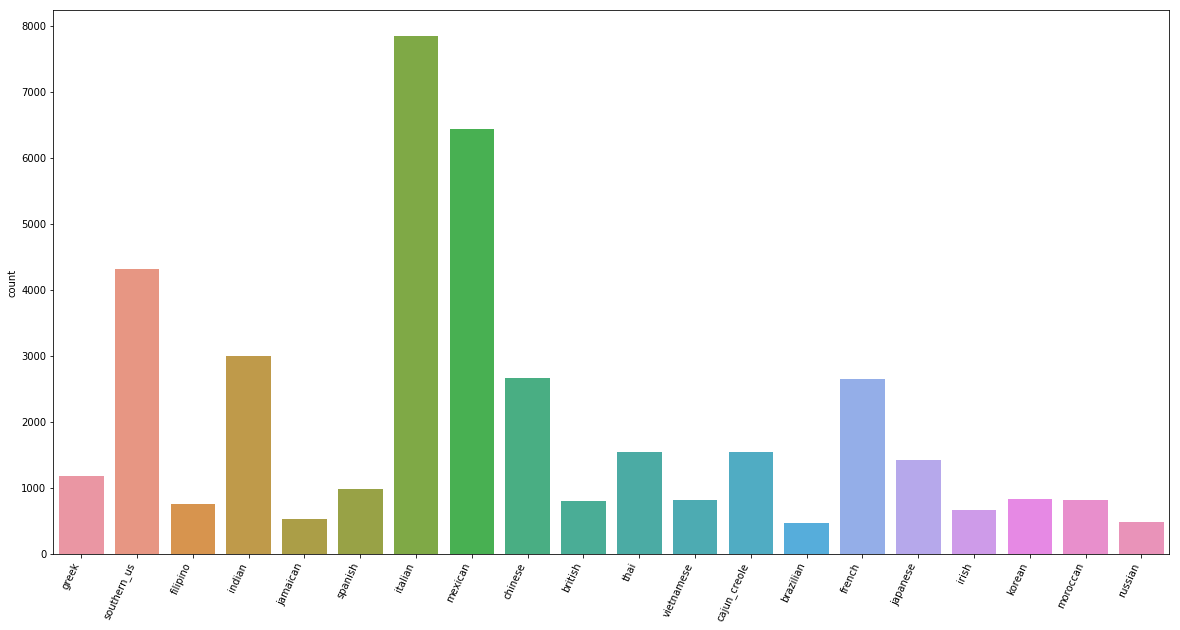

In [8]:
plt.figure(figsize=(20, 10))
chart = sns.countplot(cuisine)
ch = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')

In [9]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.5)

In [10]:
X = vectorizer.fit_transform(ingredients)

In [11]:
print(X.shape)

(39771, 1489)


In [13]:
LE = LabelEncoder()
labels = LE.fit_transform(cuisine)

In [14]:
labels

array([ 6, 16,  4, ...,  8,  3, 13])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

In [16]:
def print_metrics(y_test, ans):
    print "Accuracy ~", np.round(accuracy_score(y_test, ans), 4)
    print "F1_score ~", np.round(f1_score(y_test, ans, average="macro"), 4)

# Stacking

# LR

In [17]:
LR = LogisticRegression(solver='liblinear')
LR.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
lr_ans = LR.predict(X_test)

In [19]:
print_metrics(y_test, lr_ans)

Accuracy ~ 0.7789
F1_score ~ 0.6862


# RF

In [20]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
RF_ans = RF.predict(X_test)

In [22]:
print_metrics(y_test, RF_ans)

Accuracy ~ 0.7464
F1_score ~ 0.6423


In [23]:
X_train.shape

(26646, 1489)

In [24]:
LR.predict_proba(X_train).shape

(26646, 20)

In [33]:
RF_stack = RandomForestClassifier(n_estimators=100)
RF_stack.fit(np.hstack((X_train.toarray(), LR.predict_proba(X_train))), y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
np.hstack((X_train.toarray(), LR.predict_proba(X_train))).shape

(26646, 1509)

In [38]:
LR.predict_proba(X_train)[0]

array([0.03115834, 0.00115433, 0.63883412, 0.01677537, 0.01812302,
       0.00659297, 0.00678307, 0.00457262, 0.00124369, 0.00601156,
       0.00597282, 0.00336421, 0.00297564, 0.027369  , 0.00355923,
       0.00277761, 0.18498569, 0.02332186, 0.00809884, 0.00632603])

In [26]:
RF_predict_proba = RF_stack.predict(LR.predict_proba(X_test))

In [34]:
RF_ans_stack = RF_stack.predict(np.hstack((X_test.toarray(), LR.predict_proba(X_test))))

In [27]:
print_metrics(y_test, RF_predict_proba)

Accuracy ~ 0.7893
F1_score ~ 0.714


In [35]:
print_metrics(y_test, RF_ans_stack)

Accuracy ~ 0.7949
F1_score ~ 0.7181


# Bootstrap

In [39]:
df["cuisine"].value_counts()

italian         7837
mexican         6437
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        466
Name: cuisine, dtype: int64

In [40]:
cuisine1 = "russian"
cuisine2 = "brazilian"

In [41]:
cuisine1_df = df[df["cuisine"] == cuisine1]
cuisine2_df = df[df["cuisine"] == cuisine2]

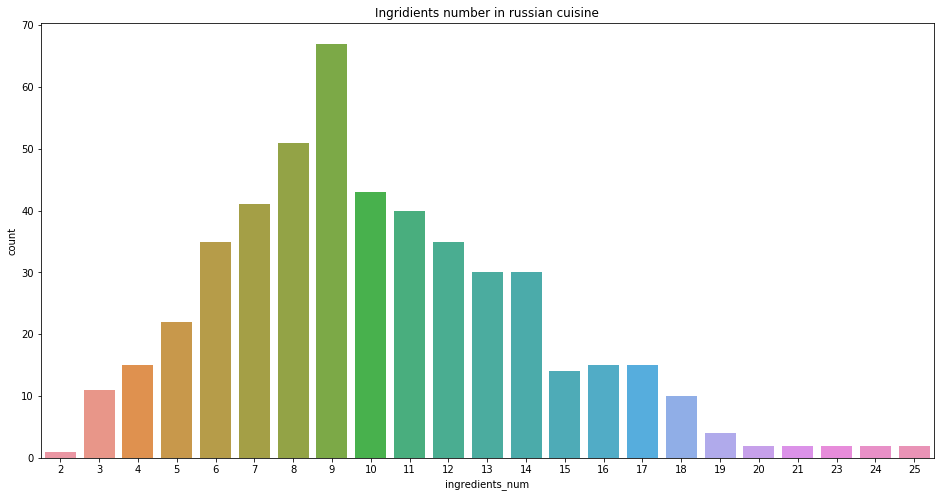

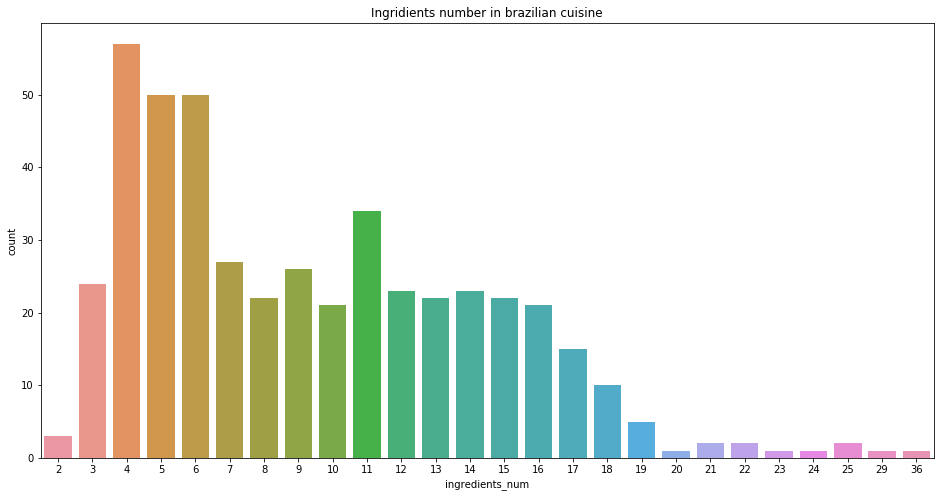

In [42]:
plt.figure(figsize=(16, 8))
plt.title("Ingridients number in {} cuisine".format(cuisine1))
sns.countplot(cuisine1_df["ingredients_num"])

plt.figure(figsize=(16, 8))
plt.title("Ingridients number in {} cuisine".format(cuisine2))
sns.countplot(cuisine2_df["ingredients_num"])

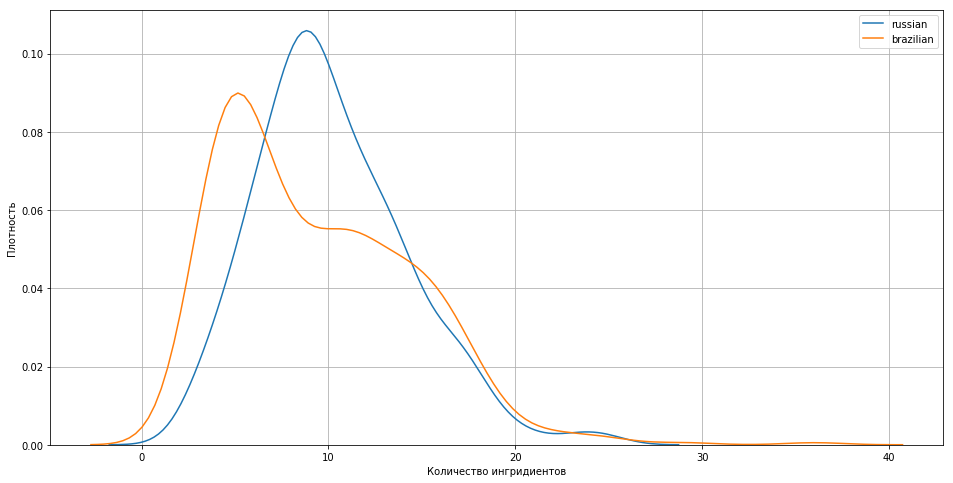

In [43]:
plt.figure(figsize=(16, 8))
fig = sns.kdeplot(cuisine1_df["ingredients_num"], label = cuisine1)
fig = sns.kdeplot(cuisine2_df["ingredients_num"], label = cuisine2)        
fig.set(xlabel=u'Количество ингридиентов', ylabel=u'Плотность')    
plt.grid()
plt.show()

Теперь было бы хорошо оценить, из скольки ингридентов в среднем состоят блюда каждой из кухонь. Так как данных в нашем датасете мало, то искать среднее не совсем правильно, лучше применить наши новые знания бутстрэпа.

In [44]:
def get_bootstrap_samples(data, n_samples):
    """Функция для генерации n_samples подвыборок с помощью бутстрэпа"""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [45]:
def stat_intervals(stat, alpha):
    """Функция для интервальной оценки"""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return np.round(boundaries, 4)

In [46]:
cuisine1_ingridients = cuisine1_df["ingredients_num"].values
cuisine2_ingridients = cuisine2_df["ingredients_num"].values

In [47]:
np.random.seed(42)

In [51]:
cuisine1_ingridients.shape

(489,)

In [49]:
get_bootstrap_samples(cuisine1_ingridients, 5000).shape

(5000, 489)

In [52]:
cuisine1_ingridients_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(cuisine1_ingridients, 5000)]
cuisine2_ingridients_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(cuisine2_ingridients, 5000)]

In [53]:
print "{} ingridients number:  mean interval".format(cuisine1),  stat_intervals(cuisine1_ingridients_scores, 0.05)
print "{} ingridients number:  mean interval".format(cuisine2),  stat_intervals(cuisine2_ingridients_scores, 0.05)

russian ingridients number:  mean interval [ 9.8814 10.5951]
brazilian ingridients number:  mean interval [8.9571 9.9013]


In [54]:
print("""В итоге мы получили, что с 95% вероятностью среднее число ингридиентов в {} кухне будет лежать в промежутке между {r[0]} и {r[1]},  в то время как в {} в среднем от {b[0]} до {b[1]}"""
.format(cuisine1, cuisine2, r=stat_intervals(cuisine1_ingridients_scores, 0.05), b=stat_intervals(cuisine2_ingridients_scores, 0.05)))

В итоге мы получили, что с 95% вероятностью среднее число ингридиентов в russian кухне будет лежать в промежутке между 9.8814 и 10.5951,  в то время как в brazilian в среднем от 8.9571 до 9.9013


# Бэггинг

In [55]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [56]:
DT_ans = DT.predict(X_test)

In [57]:
print_metrics(y_test, DT_ans)

Accuracy ~ 0.6114
F1_score ~ 0.4931


# Bagging

In [58]:
n_estimators = 10
answer = np.zeros((n_estimators, X_test.shape[0]), dtype=int)

In [64]:
for i in tqdm_notebook(range(n_estimators)):
    DT = DecisionTreeClassifier()
    index = np.random.choice(np.arange(X_train.shape[0]), X_train.shape[0])
    DT.fit(X_train[index], y_train[index])
    answer[i] = DT.predict(X_test)

In [65]:
bagging_dt_answer = [np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])]

In [68]:
answer.shape

(10, 13125)

In [72]:
answer[:, 3]

array([ 5,  2, 16,  4,  9,  2,  9,  9,  6, 16])

In [74]:
np.bincount(answer[:, 3]).argmax()

9

In [66]:
print_metrics(y_test, bagging_dt_answer)

Accuracy ~ 0.6866
F1_score ~ 0.5801


# RSM 

In [77]:
n_estimators = 10
answer = np.zeros((n_estimators, X_test.shape[0]), dtype=int)

In [78]:
for i in tqdm_notebook(range(n_estimators)):
    DT = DecisionTreeClassifier()
    features = np.random.choice(np.arange(X_train.shape[1]), X_train.shape[1] // 2, replace=False)
    DT.fit(X_train[:, features], y_train)
    answer[i] = DT.predict(X_test[:, features])

In [79]:
rsm_dt_answer = [np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])]

In [81]:
print_metrics(y_test, rsm_dt_answer)

Accuracy ~ 0.7163
F1_score ~ 0.6112


# Random Forest

In [82]:
class RandomForest():
    
    def __init__(self, n_estimators=20, max_depth=None, random_state=42):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees_ = [] # 
        self.features_idx = []
        self.random_state = random_state

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        for t in tqdm_notebook(range(self.n_estimators)):               
            # выбираем базовый алгоритм - дерево
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            # сэмплируем объекты
            index = np.random.choice(np.arange(X.shape[0]), X.shape[0])
            # сэмплируем признаки
            features = np.random.choice(np.arange(X.shape[1]), X.shape[1] // 2, replace=False)
            # обучаем
            tree.fit(X[index][:, features], y[index])
            # добавляем алгоритм к ансамблю
            self.trees_.append(tree)
            # добавляем признаки
            self.features_idx.append(features)
                   
        return self
    
    def predict(self, X):
        answer = np.zeros((len(self.trees_), X.shape[0]), dtype=int)
        # добавляем прогнозы деревьев
        for t in range(len(self.trees_)):
            answer[t] = self.trees_[t].predict(X[:, self.features_idx[t]])
            
        return np.array([np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])])

In [83]:
RF = RandomForest()
RF.fit(X_train, y_train)

<__main__.RandomForest instance at 0x7f539fda0e18>

In [85]:
RF_ans = RF.predict(X_test)

In [86]:
print_metrics(y_test, RF_ans)

Accuracy ~ 0.7287
F1_score ~ 0.6194


In [89]:
RF_stack.feature_importances_

array([1.44887805e-07, 1.20251207e-05, 1.30600585e-05, ...,
       1.55600612e-02, 2.07755716e-02, 1.60615402e-02])

In [90]:
RF_stack.feature_importances_[-20:]

array([0.01194709, 0.0163742 , 0.02062442, 0.02661542, 0.01569283,
       0.0271569 , 0.02078467, 0.03078212, 0.01611298, 0.06416142,
       0.01403308, 0.02581668, 0.01755303, 0.04860971, 0.01610467,
       0.01395695, 0.04305068, 0.01556006, 0.02077557, 0.01606154])

In [92]:
X_train.shape

(26646, 1489)

In [ ]:
1509

In [91]:
np.argsort(RF_stack.feature_importances_)[-20:]

array([1489, 1504, 1499, 1506, 1493, 1508, 1503, 1497, 1490, 1501, 1491,
       1507, 1495, 1500, 1492, 1494, 1496, 1505, 1502, 1498])

In [93]:
np.argsort(RF_stack.feature_importances_)[-20:] >= 1489

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

# Ограничим датасет для быстроты подбора параметров

british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        466

In [94]:
cutted_labels = LE.transform(["british", "filipino", "irish", "jamaican", "russian", "brazilian", "spanish"])

In [95]:
idx = []
for i in range(len(labels)):
    if labels[i] in cutted_labels:
        idx.append(i)
idx = np.array(idx)

In [96]:
X, y = X[idx], labels[idx]

In [97]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [98]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
temp_train_acc = []
temp_test_acc = []
temp_train_f1 = []
temp_test_f1 = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    RFC.fit(X_train, y_train)
    temp_train_acc.append(accuracy_score(RFC.predict(X_train), y_train))
    temp_train_f1.append(f1_score(RFC.predict(X_train), y_train, average="macro"))
    temp_test_acc.append(accuracy_score(RFC.predict(X_test), y_test))
    temp_test_f1.append(f1_score(RFC.predict(X_test), y_test, average="macro"))

In [99]:
print "f1_score is", np.round(np.mean(temp_test_f1), 5)
print "accuracy is", np.round(np.mean(temp_test_acc), 5)

f1_score is 0.73045
accuracy is 0.73936


In [100]:
def visualize(test_metric_acc, train_metric_acc, test_metric_f1, train_metric_f1, grid, xlabel='X'):

    train_acc, test_acc = np.asarray(train_metric_acc), np.asarray(test_metric_acc)
    train_f1, test_f1 = np.asarray(train_metric_f1), np.asarray(test_metric_f1)
    print "Best accuracy_score on CV is {:.4f} with {}".format(max(test_acc.mean(axis=1)), 
                                                    grid[np.argmax(test_acc.mean(axis=1))]), xlabel
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.title("Accuracy")
    plt.plot(grid, test_acc.mean(axis=1), label="test")
    plt.plot(grid, train_acc.mean(axis=1), label="train")
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()
    
    print "Best f1_score on CV is {:.4f} with {}".format(max(test_f1.mean(axis=1)), 
                                                    grid[np.argmax(test_f1.mean(axis=1))]), xlabel
    
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.title("F1_score")
    plt.plot(grid, test_f1.mean(axis=1), label="test")
    plt.plot(grid, train_f1.mean(axis=1), label="train")
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

In [101]:
def CV(RFC, X, y):

    temp_train_acc = []
    temp_test_acc = []
    temp_train_f1 = []
    temp_test_f1 = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        RFC.fit(X_train, y_train)
        train_ans = RFC.predict(X_train)
        test_ans = RFC.predict(X_test)
        temp_train_acc.append(accuracy_score(y_train, train_ans))
        temp_train_f1.append(f1_score(y_train, train_ans, average="macro"))
        temp_test_acc.append(accuracy_score(y_test, test_ans))
        temp_test_f1.append(f1_score(y_test, test_ans, average="macro"))
    
    return temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1

# Количество деревьев в ансамбле

In [102]:
train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

for ntrees in tqdm_notebook(trees_grid):
    RFC = RandomForestClassifier(n_estimators=ntrees, random_state=42)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(RFC, X, y)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_score on CV is 0.7394 with 100 trees number


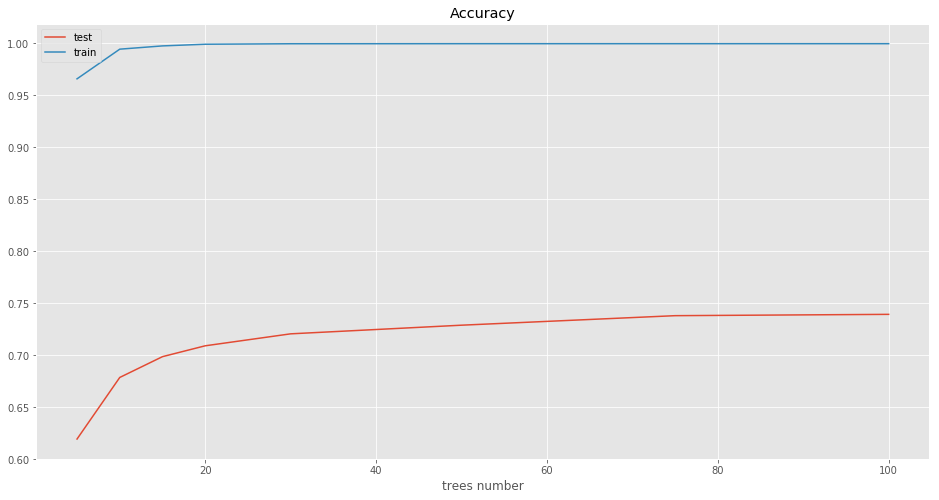

Best f1_score on CV is 0.7304 with 100 trees number


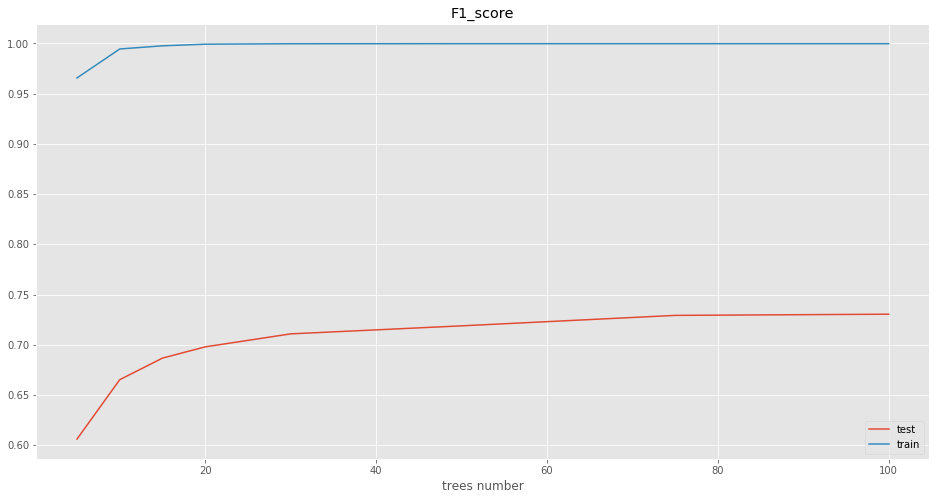

In [103]:
visualize(test_acc, train_acc, test_f1, train_f1, trees_grid, "trees number")

# Глубина леса

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
max_depth_grid = [5, 10, 15, 20, 30, 50, 100, 150, -1]

for max_depth in tqdm_notebook(max_depth_grid):
    RFC = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=max_depth)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(RFC, X, y)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_score on CV is 0.7423 with 50 max_depth


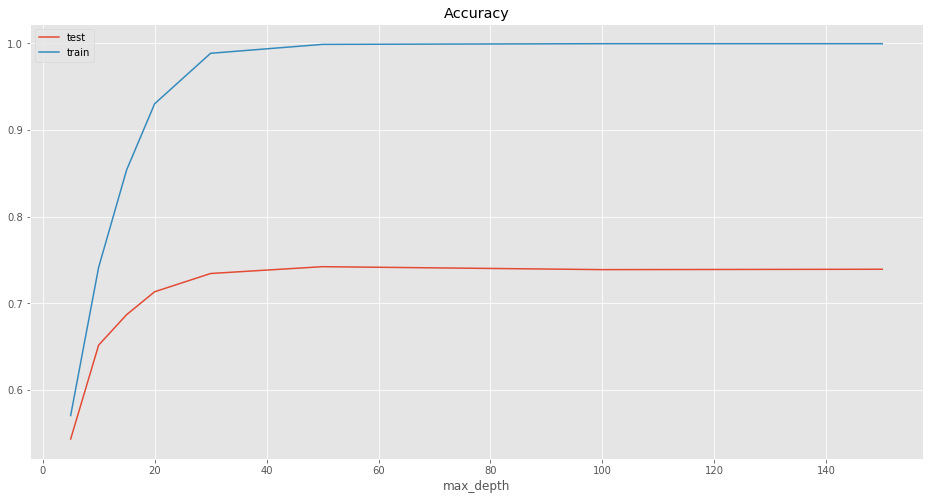

Best f1_score on CV is 0.7319 with 50 max_depth


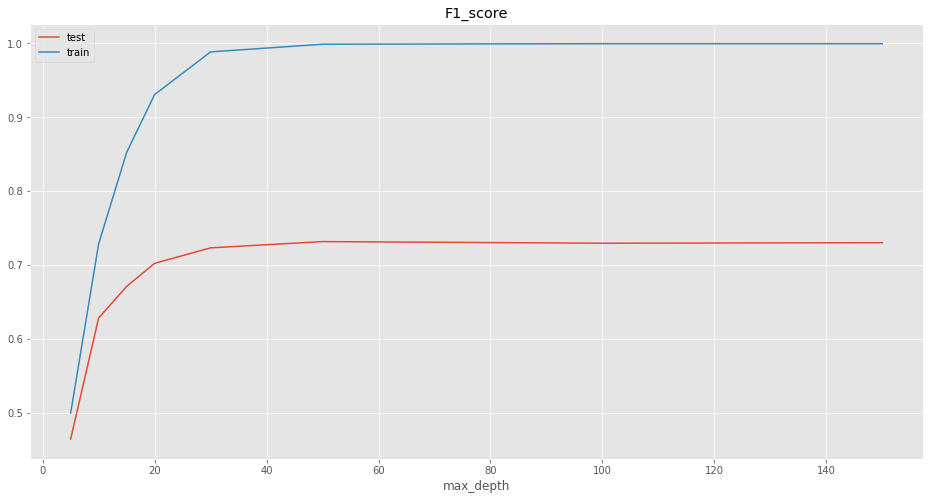

In [105]:
visualize(test_acc, train_acc, test_f1, train_f1, max_depth_grid[:-1], "max_depth")

# MAX_FEATURES

##### По умолчанию он равен sqrt(n) в задачах классификации и n/3 в задачах регрессии

In [106]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
max_features_grid = [5, 10, 15, 20, 38, 50, 100, 500, 1000]

for max_features in tqdm_notebook(max_features_grid):
    RFC = RandomForestClassifier(n_estimators=100, random_state=42, max_features=max_features)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(RFC, X, y)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_score on CV is 0.7573 with 5 max_features


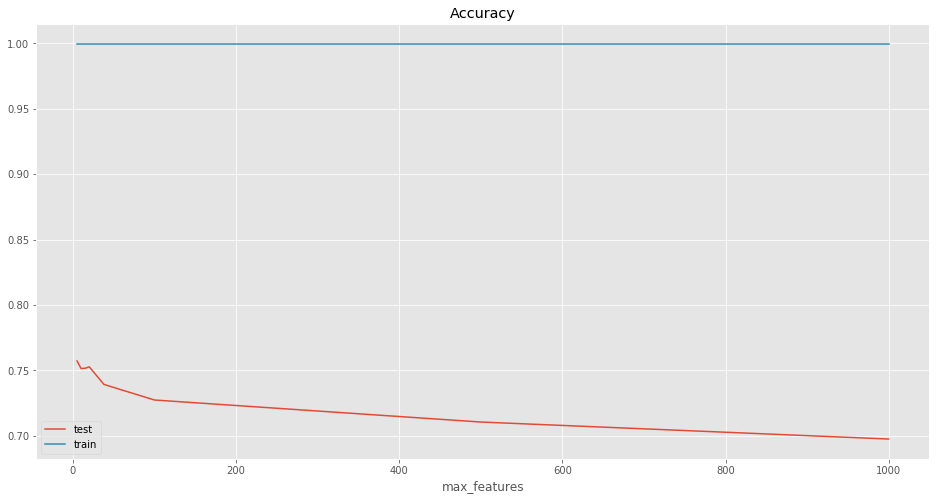

Best f1_score on CV is 0.7472 with 5 max_features


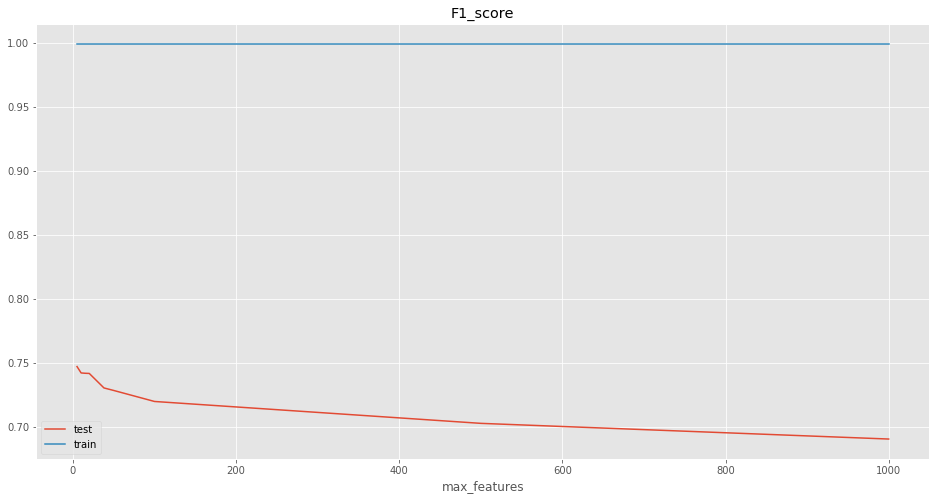

In [107]:
visualize(test_acc, train_acc, test_f1, train_f1, max_features_grid, "max_features")

# MIN SAMPLES LEAF

По классике, в задачах регрессии рекомендуется использовать значение 5

In [108]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_acc = []
test_acc = []
train_f1 = []
test_f1 = []
min_samples_leaf_grid = [1, 3, 5, 7, 10, 15, 20, 25]

for min_samples_leaf in tqdm_notebook(min_samples_leaf_grid):
    RFC = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=min_samples_leaf)
    temp_train_acc, temp_test_acc, temp_train_f1, temp_test_f1 = CV(RFC, X, y)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    train_f1.append(temp_train_f1)
    test_f1.append(temp_test_f1)

Best accuracy_score on CV is 0.7394 with 1 min_samples_leaf_grid


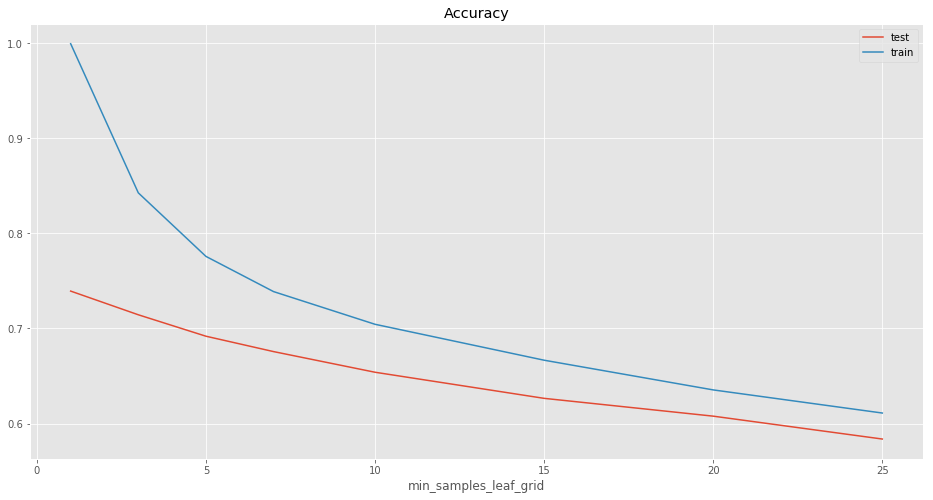

Best f1_score on CV is 0.7304 with 1 min_samples_leaf_grid


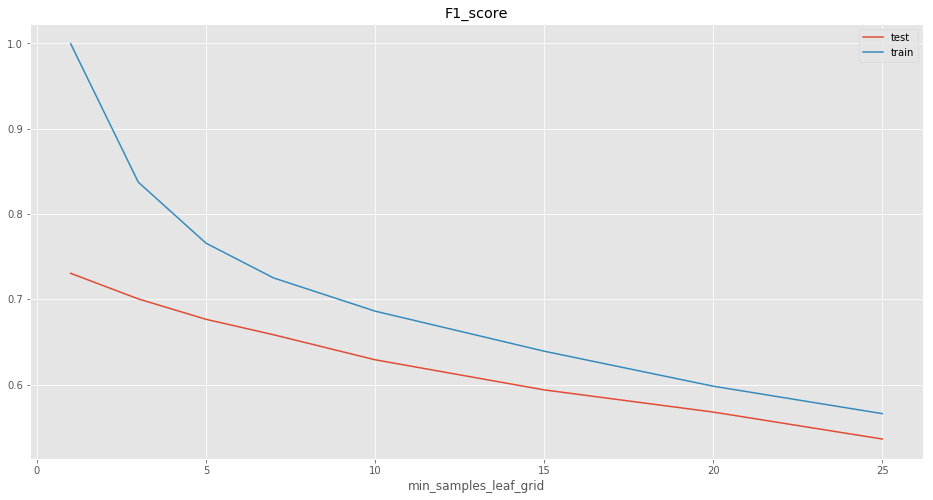

In [109]:
visualize(test_acc, train_acc, test_f1, train_f1, min_samples_leaf_grid, "min_samples_leaf_grid")

In [111]:
parameters = {'max_features': [1, 5, 10, 15, 20, 38, 50], 
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth': [5, 10, 15, 20, 30, 50]}
rfc = RandomForestClassifier(n_estimators=10, random_state=42, 
                             n_jobs=18, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=18, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:   10.6s
[Parallel(n_jobs=18)]: Done 164 tasks      | elapsed:   16.8s
[Parallel(n_jobs=18)]: Done 414 tasks      | elapsed:   22.9s
[Parallel(n_jobs=18)]: Done 764 tasks      | elapsed:   31.4s
[Parallel(n_jobs=18)]: Done 840 out of 840 | elapsed:   33.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=18,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=18,
       param_grid={'max_features': [1, 5, 10, 15, 20, 38, 50], 'max_depth': [5, 10, 15, 20, 30, 50], 'min_samples_leaf': [1, 3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [112]:
gcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=38, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=18,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [113]:
gcv.best_score_

0.6827086882453152

# Градиентный Бустинг

# Для простоты рассмотрим регрессию

In [114]:
from sklearn.metrics import mean_squared_error as mse

In [115]:
wine = pd.read_csv("winequality-red.csv")

In [116]:
X = wine.values[:, :-1]
y = wine.values[:, -1]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(wine.values[:, :-1], wine.values[:, -1], test_size=0.33, random_state=42)

$MSE(y, p) = \frac{1}{n} (y-p)^T(y-p) = \frac{1}{n} \sum\limits_{i=1}^n(y_i - p_i)^2$

$(\frac{1}{n} (y_j - p_j)^2)' = -\frac{2}{n} (y_j - p_j) = \frac{2}{n} (p_j - y_j)$

$\nabla MSE - ?$

Каждый следующий алгоритм тоже будем настраивать на остатки предыдущих

Заметим, что остатки могут быть найдены как антиградиент функции потерь по ответу модели, посчитанный в точке ответа уже построенной композиции

In [122]:
class GradientBoosting():
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones(len(y))
        self.loss_by_iter = [] # функция потерь на каждой итерации
        self.trees_ = []
        self.random_state = random_state
        
    def mse_grad(self, y, p):
        # написать градиент
        return 2. * (p - y) / len(y)

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        for t in tqdm_notebook(range(self.n_estimators)):               
            # считаем - антиградиент
            resid = -self.mse_grad(y, prediction)
            # выбираем базовый алгоритм
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            # обучаемся на векторе антиградиента
            tree.fit(X, resid)
            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X)
            #добавляем дерево в ансамбль
            self.trees_.append(tree)
            # обновляем текущее приближение (lr * b)
            prediction += self.learning_rate * b
            
            # обновляем лосс на обучении (опционально)
            self.loss_by_iter.append(mse(y, prediction))
            
        return self
    
    def predict(self, X):
        # сначала инициализируем прогноз на тестовой выборке – 
        # это просто вектор из средних значений ответов на обучении
        pred = np.ones(X.shape[0]) * np.mean(self.y)
        # добавляем прогнозы деревьев * lr
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X)
            
        return pred

In [128]:
tree = GradientBoosting(n_estimators=100, learning_rate=1., max_depth=None)
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.5704116343715265

In [129]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.7367424242424242

In [136]:
y

array([5., 5., 5., ..., 6., 5., 6.])

In [139]:
np.ones(len(y)) * np.mean(y)

array([5.63602251, 5.63602251, 5.63602251, ..., 5.63602251, 5.63602251,
       5.63602251])

In [130]:
class StohasticGradientBoosting():
    
    def __init__(self, n_estimators=500, learning_rate=0.1, max_depth=-1, random_state=42):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones(len(y))
        self.loss_by_iter = [] # функция потерь на каждой итерации
        self.trees_ = []
        self.random_state = random_state
        
    def mse_grad(self, y, p):
        # написать градиент
        return 2. * (p - y) / len(y)

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        for t in tqdm_notebook(range(self.n_estimators)):  
            index = np.random.choice(np.arange(X.shape[0]), X.shape[0])
            # считаем - антиградиент
            resid = -self.mse_grad(y, prediction)
            # выбираем базовый алгоритм
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            # обучаемся на векторе антиградиента
            tree.fit(X[index], resid[index])
            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X)
            #добавляем дерево в ансамбль
            self.trees_.append(tree)
            # обновляем текущее приближение (lr * b)
            prediction += self.learning_rate * b
            # обновляем лосс на обучении (опционально)
            self.loss_by_iter.append(mse(y, prediction))
            
        return self
    
    def predict(self, X):
        # сначала инициализируем прогноз на тестовой выборке – 
        # это просто вектор из средних значений ответов на обучении
        pred = np.ones(X.shape[0]) * np.mean(self.y)
        # добавляем прогнозы деревьев * lr
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X)
            
        return pred

In [133]:
tree = GradientBoosting(n_estimators=500, learning_rate=1., max_depth=None)
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.46299196213134935

In [134]:
from lightgbm import LGBMRegressor

LGBM = LGBMRegressor(n_estimators=500)
LGBM.fit(X_train, y_train.ravel())
LGBM_ans = LGBM.predict(X_test)
mse(y_test, LGBM_ans)

0.41309086015684054

In [135]:
def visualize(test_metric_mse, train_metric_mse, grid, xlabel='X'):

    train_mse, test_mse = np.asarray(train_metric_mse), np.asarray(test_metric_mse)
    print "Best MSE on CV is {:.4f} with {}".format(min(test_mse.mean(axis=1)), 
                                                    grid[np.argmin(test_mse.mean(axis=1))]), xlabel
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.title("MSE")
    plt.plot(grid, test_mse.mean(axis=1), label="test")
    plt.plot(grid, train_mse.mean(axis=1), label="train")
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

# Параметры Градиентного бустинга

# Learning Rate

In [146]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_mse = []
test_mse = []
learning_rates = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.]

for lr in tqdm_notebook(learning_rates):
    LGBM = LGBMRegressor(learning_rate=lr)
    temp_train_mse = []
    temp_test_mse = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LGBM.fit(X_train, y_train)
        temp_train_mse.append(mse(LGBM.predict(X_train), y_train))
        temp_test_mse.append(mse(LGBM.predict(X_test), y_test))
    train_mse.append(temp_train_mse)
    test_mse.append(temp_test_mse)

Best MSE on CV is 0.3564 with 0.05 learning rate


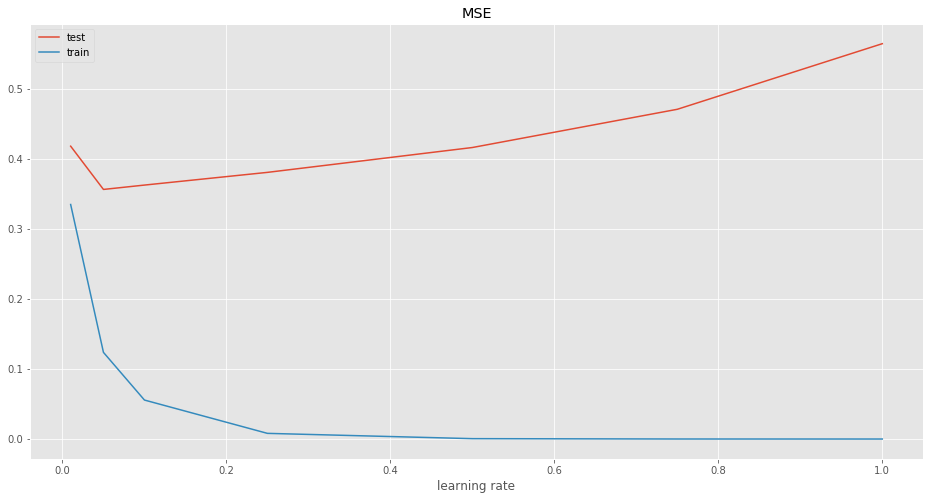

In [147]:
visualize(test_mse, train_mse, learning_rates, "learning rate")

# n_estimators

In [142]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_mse = []
test_mse = []
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 1000, 3000]

for n in tqdm_notebook(n_estimators):
    LGBM = LGBMRegressor(n_estimators=n)
    temp_train_mse = []
    temp_test_mse = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        LGBM.fit(X_train, y_train)
        temp_train_mse.append(mse(LGBM.predict(X_train), y_train))
        temp_test_mse.append(mse(LGBM.predict(X_test), y_test))
    train_mse.append(temp_train_mse)
    test_mse.append(temp_test_mse)

Best MSE on CV is 0.3617 with 64 n_estimators


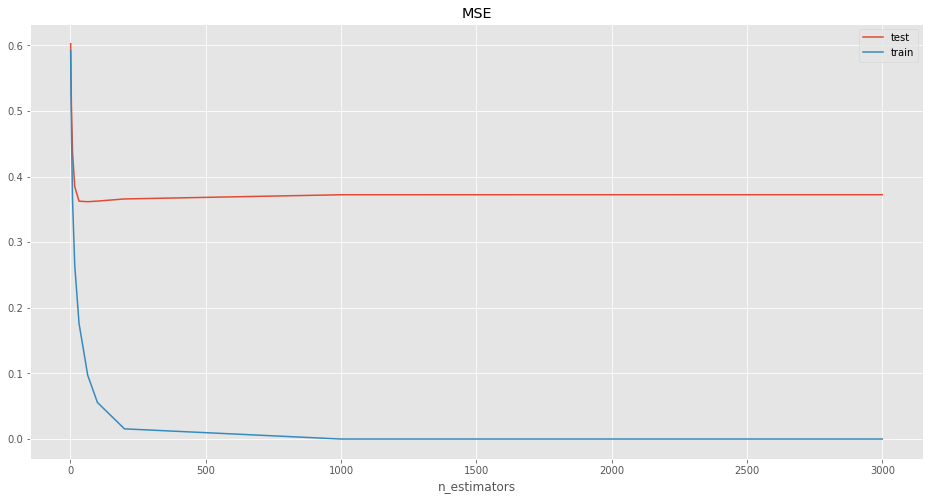

In [143]:
visualize(test_mse, train_mse, n_estimators, "n_estimators")

In [145]:
[np.mean(i) for i in test_mse]

[0.6025276996738773,
 0.5629534122534988,
 0.504662305742507,
 0.4366363054474422,
 0.3847158762950588,
 0.36247659628359374,
 0.3617080612822406,
 0.3626165117472869,
 0.36590955533267316,
 0.3722888008029468,
 0.37236484661533187]